In [9]:
import numpy as np
import pandas as pd
import sqlite3

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [ ]:
df_raw = pd.read_csv('database/IMDB Dataset.csv')
df_raw.head()

In [ ]:
#nlp=spacy.load(r'C:\Users\dakot\anaconda3\envs\youtube_nlp\Lib\site-packages\en_core_web_lg\en_core_web_lg-3.2.0')

try:
    nlp = spacy.load("en_core_web_lg")
except: # If not present, we download
    spacy.cli.download("en_core_web_lg")
    nlp = spacy.load("en_core_web_lg")

In [ ]:
# We just want the vectors so we can turn off other models in the pipeline
with nlp.disable_pipes():
    vectors = np.array([nlp(review.review).vector for idx, review in df_raw.iterrows()])
    
vectors.shape

In [ ]:
#Establish connection to the IMDB DB
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\youtube_sentiment_analysis\IMDB_sentiment_model_building_db.db")

df_raw.to_sql(name=f'raw_data',con=conn,schema='IMDB_sentiment_model_building_db.db',if_exists='replace') 


In [ ]:
df_vectors.to_sql(name=f'spacy_word_vectors_lg',con=conn,schema='IMDB_sentiment_model_building_db.db',if_exists='replace') 


In [ ]:
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\youtube_sentiment_analysis\IMDB_sentiment_model_building_db.db")

df_test = pd.read_sql_query("SELECT * FROM spacy_word_vectors_lg", conn, index_col=None)

In [12]:
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\youtube_sentiment_analysis\IMDB_sentiment_model_building_db.db")

df_vectors = pd.read_sql_query("SELECT * FROM spacy_word_vectors_lg", conn, index_col=None)

In [13]:
X=df_vectors.drop(columns=['index','review','sentiment'])
y=df_vectors['sentiment']

y=pd.get_dummies(y)
y=y[['positive']].rename(columns={'positive': 'sentiment'})

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)

In [15]:
model_wordEmbedding_svc=LinearSVC(random_state=1, dual=False)
model_wordEmbedding_svc.fit(X_train, y_train)

print(f'Model test accuracy: {model_wordEmbedding_svc.score(X_test, y_test)*100:.3f}%')



C:\Users\dakot\anaconda3\envs\youtube_nlp\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model test accuracy: 86.030%


[[4322  722]
 [ 675 4281]]
Accuracy:  0.8603


Text(0.5, 15.0, 'Predicted Label')

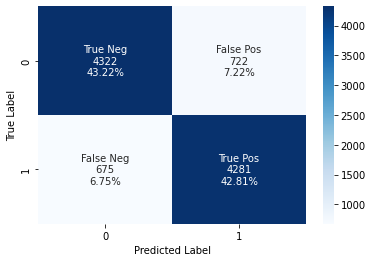

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_predicted=model_wordEmbedding_svc.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
conMat = confusion_matrix(y_test, y_predicted)
print(conMat)
print("Accuracy: ", accuracy )

labels=["True Neg","False Pos","False Neg","True Pos"]
group_counts = [f"{int(value)}" for value in conMat.flatten()]
group_percentages = [f"{round(percent*100,2)}%" for percent in conMat.flatten()/np.sum(conMat)]

annotations = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]

annotations = np.asarray(annotations).reshape(2,2)
sns.heatmap(conMat, fmt="", annot=annotations, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [17]:
#Serialize our two day model 
import pickle
modelFile = open('model_wordEmbedding_svc.p', 'wb')
pickle.dump(model_wordEmbedding_svc, modelFile)                     
modelFile.close()

In [18]:
#Test our serialized model before deployment
modelFile = open('model_wordEmbedding_svc.p', 'rb')     
pmodel = pickle.load(modelFile)
y_predp=pmodel.predict(X_test)
modelFile.close()

accuracy_score(y_test, y_predp)

0.8603